# Problem Statement

This dataset contains insurance claim statistics on  customers. We are tasked with predicting 'TARGET_FLAG' for each customer given 23 features. As our target is a binary number (0 & 1), this is a **classification problem**.

In terms of metrics, we can use **accuracy**, **precision**, **recall** and **F1-scores** to calculate performance of our methods.

While in this case study the data source and reliability is unknown, we should in practise assess these as well (alongside unwanted biases and other ethical considerations).

# Data loading & pre-processing

In [1]:
!pip install scikit-plot
!pip install sklearn-pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from scipy.stats import loguniform
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
f1_score, roc_auc_score, roc_curve, precision_score, recall_score
from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn_pandas import CategoricalImputer

In [3]:
#Import train data

df = pd.read_csv('/content/train_auto.csv')
df.drop(columns='INDEX',inplace=True)
df.drop(columns='TARGET_AMT',inplace=True) # Not needed for this case study

df_original = df.copy(deep=True)

df.head()

TARGET_FLAG  KIDSDRIV   AGE  HOMEKIDS   YOJ    INCOME PARENT1  HOME_VAL  \
0            0         0  60.0         0  11.0   $67,349      No        $0   
1            0         0  43.0         0  11.0   $91,449      No  $257,252   
2            0         0  35.0         1  10.0   $16,039      No  $124,191   
3            0         0  51.0         0  14.0       NaN      No  $306,251   
4            0         0  50.0         0   NaN  $114,986      No  $243,925   

  MSTATUS  SEX  ... BLUEBOOK TIF  CAR_TYPE RED_CAR OLDCLAIM  CLM_FREQ REVOKED  \
0    z_No    M  ...  $14,230  11   Minivan     yes   $4,461         2      No   
1    z_No    M  ...  $14,940   1   Minivan     yes       $0         0      No   
2     Yes  z_F  ...   $4,010   4     z_SUV      no  $38,690         2      No   
3     Yes    M  ...  $15,440   7   Minivan     yes       $0         0      No   
4     Yes  z_F  ...  $18,000   1     z_SUV      no  $19,217         2     Yes   

  MVR_PTS CAR_AGE           URBANICITY  
0       3    18.0  Highly Urban/ Urban  
1       0     1.0  Highly Urban/ Urban  
2       3    10.0  Highly Urban/ Urban  
3       0     6.0  Highly Urban/ Urban  
4       3    17.0  Highly Urban/ Urban  

[5 rows x 24 columns]

In [4]:
print('The Dataset consists of {} features & {} samples.'.format(df.shape[1]-1, df.shape[0]))

The Dataset consists of 23 features & 8161 samples.


In [5]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  8161 non-null   int64  
 1   KIDSDRIV     8161 non-null   int64  
 2   AGE          8155 non-null   float64
 3   HOMEKIDS     8161 non-null   int64  
 4   YOJ          7707 non-null   float64
 5   INCOME       7716 non-null   object 
 6   PARENT1      8161 non-null   object 
 7   HOME_VAL     7697 non-null   object 
 8   MSTATUS      8161 non-null   object 
 9   SEX          8161 non-null   object 
 10  EDUCATION    8161 non-null   object 
 11  JOB          7635 non-null   object 
 12  TRAVTIME     8161 non-null   int64  
 13  CAR_USE      8161 non-null   object 
 14  BLUEBOOK     8161 non-null   object 
 15  TIF          8161 non-null   int64  
 16  CAR_TYPE     8161 non-null   object 
 17  RED_CAR      8161 non-null   object 
 18  OLDCLAIM     8161 non-null   object 
 19  CLM_FR

You can see that we need to convert categorical features into int/float, as well as deal with NaN values (i.e. dropping).

<!-- However, with some contextual information we could attempt to impute. -->

In [6]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6045 entries, 0 to 8160
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  6045 non-null   int64  
 1   KIDSDRIV     6045 non-null   int64  
 2   AGE          6045 non-null   float64
 3   HOMEKIDS     6045 non-null   int64  
 4   YOJ          6045 non-null   float64
 5   INCOME       6045 non-null   object 
 6   PARENT1      6045 non-null   object 
 7   HOME_VAL     6045 non-null   object 
 8   MSTATUS      6045 non-null   object 
 9   SEX          6045 non-null   object 
 10  EDUCATION    6045 non-null   object 
 11  JOB          6045 non-null   object 
 12  TRAVTIME     6045 non-null   int64  
 13  CAR_USE      6045 non-null   object 
 14  BLUEBOOK     6045 non-null   object 
 15  TIF          6045 non-null   int64  
 16  CAR_TYPE     6045 non-null   object 
 17  RED_CAR      6045 non-null   object 
 18  OLDCLAIM     6045 non-null   object 
 19  CLM_FR

In [7]:
#Checking number of unique items in each feature

df.nunique()

TARGET_FLAG       2
KIDSDRIV          5
AGE              59
HOMEKIDS          6
YOJ              21
INCOME         5243
PARENT1           2
HOME_VAL       4039
MSTATUS           2
SEX               2
EDUCATION         5
JOB               8
TRAVTIME         96
CAR_USE           2
BLUEBOOK       2431
TIF              23
CAR_TYPE          6
RED_CAR           2
OLDCLAIM       2126
CLM_FREQ          6
REVOKED           2
MVR_PTS          13
CAR_AGE          30
URBANICITY        2
dtype: int64

In [8]:
#Checking the stats of all the columns

df.describe()

TARGET_FLAG     KIDSDRIV          AGE     HOMEKIDS          YOJ  \
count  6045.000000  6045.000000  6045.000000  6045.000000  6045.000000   
mean      0.265012     0.173201    44.628453     0.743424    10.494624   
std       0.441376     0.515424     8.707805     1.132740     4.138508   
min       0.000000     0.000000    16.000000     0.000000     0.000000   
25%       0.000000     0.000000    39.000000     0.000000     9.000000   
50%       0.000000     0.000000    45.000000     0.000000    11.000000   
75%       1.000000     0.000000    51.000000     1.000000    13.000000   
max       1.000000     4.000000    81.000000     5.000000    23.000000   

          TRAVTIME          TIF     CLM_FREQ      MVR_PTS      CAR_AGE  
count  6045.000000  6045.000000  6045.000000  6045.000000  6045.000000  
mean     33.694293     5.360298     0.784119     1.699752     7.920926  
std      15.892961     4.144664     1.153884     2.157899     5.583880  
min       5.000000     1.000000     0.000000     0.000000    -3.000000  
25%      23.000000     1.000000     0.000000     0.000000     1.000000  
50%      33.000000     4.000000     0.000000     1.000000     8.000000  
75%      44.000000     7.000000     2.000000     3.000000    12.000000  
max     142.000000    25.000000     5.000000    13.000000    28.000000

The stats seem to be okay, except for a minimum car age of -3.

In [9]:
df = df[df['CAR_AGE'] != -3]

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6044 entries, 0 to 8160
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  6044 non-null   int64  
 1   KIDSDRIV     6044 non-null   int64  
 2   AGE          6044 non-null   float64
 3   HOMEKIDS     6044 non-null   int64  
 4   YOJ          6044 non-null   float64
 5   INCOME       6044 non-null   object 
 6   PARENT1      6044 non-null   object 
 7   HOME_VAL     6044 non-null   object 
 8   MSTATUS      6044 non-null   object 
 9   SEX          6044 non-null   object 
 10  EDUCATION    6044 non-null   object 
 11  JOB          6044 non-null   object 
 12  TRAVTIME     6044 non-null   int64  
 13  CAR_USE      6044 non-null   object 
 14  BLUEBOOK     6044 non-null   object 
 15  TIF          6044 non-null   int64  
 16  CAR_TYPE     6044 non-null   object 
 17  RED_CAR      6044 non-null   object 
 18  OLDCLAIM     6044 non-null   object 
 19  CLM_FR

TARGET_FLAG     KIDSDRIV          AGE     HOMEKIDS          YOJ  \
count  6044.000000  6044.000000  6044.000000  6044.000000  6044.000000   
mean      0.264891     0.173230    44.628061     0.743547    10.494375   
std       0.441312     0.515462     8.708472     1.132793     4.138805   
min       0.000000     0.000000    16.000000     0.000000     0.000000   
25%       0.000000     0.000000    39.000000     0.000000     9.000000   
50%       0.000000     0.000000    45.000000     0.000000    11.000000   
75%       1.000000     0.000000    51.000000     1.000000    13.000000   
max       1.000000     4.000000    81.000000     5.000000    23.000000   

          TRAVTIME          TIF     CLM_FREQ      MVR_PTS      CAR_AGE  
count  6044.000000  6044.000000  6044.000000  6044.000000  6044.000000  
mean     33.692257     5.360523     0.783752     1.699868     7.922733  
std      15.893488     4.144970     1.153627     2.158059     5.582574  
min       5.000000     1.000000     0.000000     0.000000     0.000000  
25%      23.000000     1.000000     0.000000     0.000000     1.000000  
50%      33.000000     4.000000     0.000000     1.000000     8.000000  
75%      44.000000     7.000000     2.000000     3.000000    12.000000  
max     142.000000    25.000000     5.000000    13.000000    28.000000

In [10]:
#Removal of any duplicate rows (if any)

r,c = df.shape

# df1 = df.copy()
df.drop_duplicates(inplace=True)
df.reset_index(drop=True,inplace=True)

if df.shape==(r,c):
    print('The dataset doesn\'t have any duplicates')
else:
    print(f'Number of duplicates dropped ---> {r-df.shape[0]}')

The dataset doesn't have any duplicates


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


We also wish to clean some of the data:

In [11]:
#Remove '$' & ',' from INCOME:
df['INCOME'] = df['INCOME'].str.replace('$', '').str.replace(',', '').astype(int)

#Remove '$' & ',' from HOME_VAL:
df['HOME_VAL'] = df['HOME_VAL'].str.replace('$', '').str.replace(',', '').astype(int)

#Remove '$' & ',' from BLUEBOOK:
df['BLUEBOOK'] = df['BLUEBOOK'].str.replace('$', '').str.replace(',', '').astype(int)

#Remove '$' & ',' from OLDCLAIM:
df['OLDCLAIM'] = df['OLDCLAIM'].str.replace('$', '').str.replace(',', '').astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character r

In [12]:
df.head()

TARGET_FLAG  KIDSDRIV   AGE  HOMEKIDS   YOJ  INCOME PARENT1  HOME_VAL  \
0            0         0  60.0         0  11.0   67349      No         0   
1            0         0  43.0         0  11.0   91449      No    257252   
2            0         0  35.0         1  10.0   16039      No    124191   
3            1         0  34.0         1  12.0  125301     Yes         0   
4            1         0  34.0         0  10.0   62978      No         0   

  MSTATUS  SEX  ... BLUEBOOK TIF    CAR_TYPE RED_CAR  OLDCLAIM  CLM_FREQ  \
0    z_No    M  ...    14230  11     Minivan     yes      4461         2   
1    z_No    M  ...    14940   1     Minivan     yes         0         0   
2     Yes  z_F  ...     4010   4       z_SUV      no     38690         2   
3    z_No  z_F  ...    17430   1  Sports Car      no         0         0   
4    z_No  z_F  ...    11200   1       z_SUV      no         0         0   

  REVOKED MVR_PTS  CAR_AGE           URBANICITY  
0      No       3     18.0  Highly Urban/ Urban  
1      No       0      1.0  Highly Urban/ Urban  
2      No       3     10.0  Highly Urban/ Urban  
3      No       0      7.0  Highly Urban/ Urban  
4      No       0      1.0  Highly Urban/ Urban  

[5 rows x 24 columns]

In [13]:
#stats for test imputation...

s_age = df['AGE'].mean()
s_yoj = df['YOJ'].mean()
s_car_age = df['CAR_AGE'].mean()
s_income = df['INCOME'].mean()
s_home_val = df['HOME_VAL'].mean()
s_job = df['JOB'].mode()

# EDA

            Target Variable Distribution           


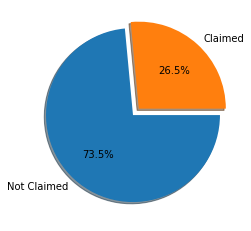

In [14]:
#Let us first analyze the distribution of the target variable

target = 'TARGET_FLAG'
labels = ['Not Claimed','Claimed']

MAP={}
for e, i in enumerate(sorted(df[target].unique())):
    MAP[i]=labels[e]

df1 = df.copy()
df1[target]=df1[target].map(MAP)
explode=np.zeros(len(labels))
explode[-1]=0.1
print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(df1[target].value_counts(), labels=df1[target].value_counts().index, counterclock=False, shadow=True, 
        explode=explode, autopct='%1.1f%%', radius=1, startangle=0)
plt.show()

Indeed, we can see that the training data is unbalanced, i.e. accuracy will not be a good reflection of performance.

In [15]:
#Seperating categorical and ordinal features

features = [i for i in df.columns.values if i not in [target]]

cf = ['PARENT1','MSTATUS','SEX','EDUCATION','JOB','CAR_USE','CAR_TYPE','RED_CAR','REVOKED','URBANICITY']
nf = []
for i in df[features].columns:
  if i not in cf:
    nf.append(i)

print('The Dataset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))

The Dataset has 13 numerical & 10 categorical features.


Visualising the categorical & numerical data helps us understand the distributions of them.

                               Visualising Categorical Features:                                


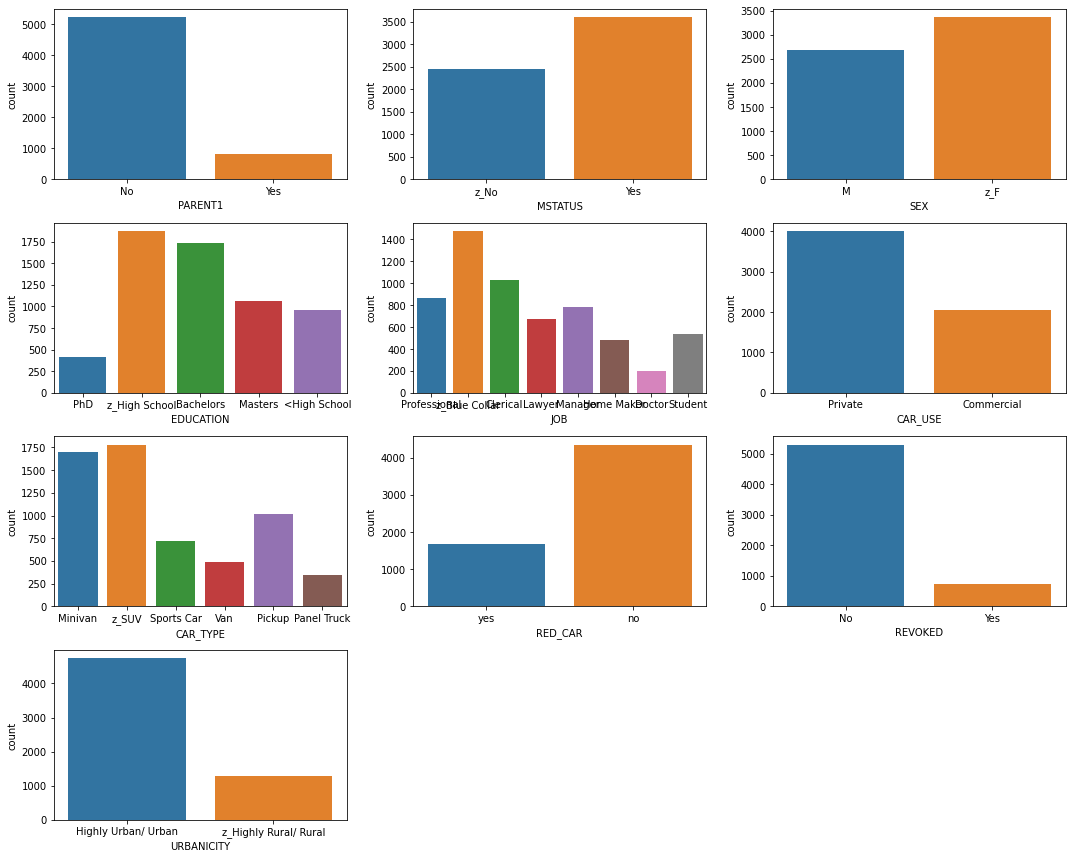

In [16]:
#Visualising the categorical features 

print('\033[1mVisualising Categorical Features:'.center(100))

n=3
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=24:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(x=df[cf[i]])
    else:
        plt.subplot(3,1,i-1)
        sns.countplot(x=df[cf[i]])
plt.tight_layout()
plt.show()


                                     Features Distribution                                      


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

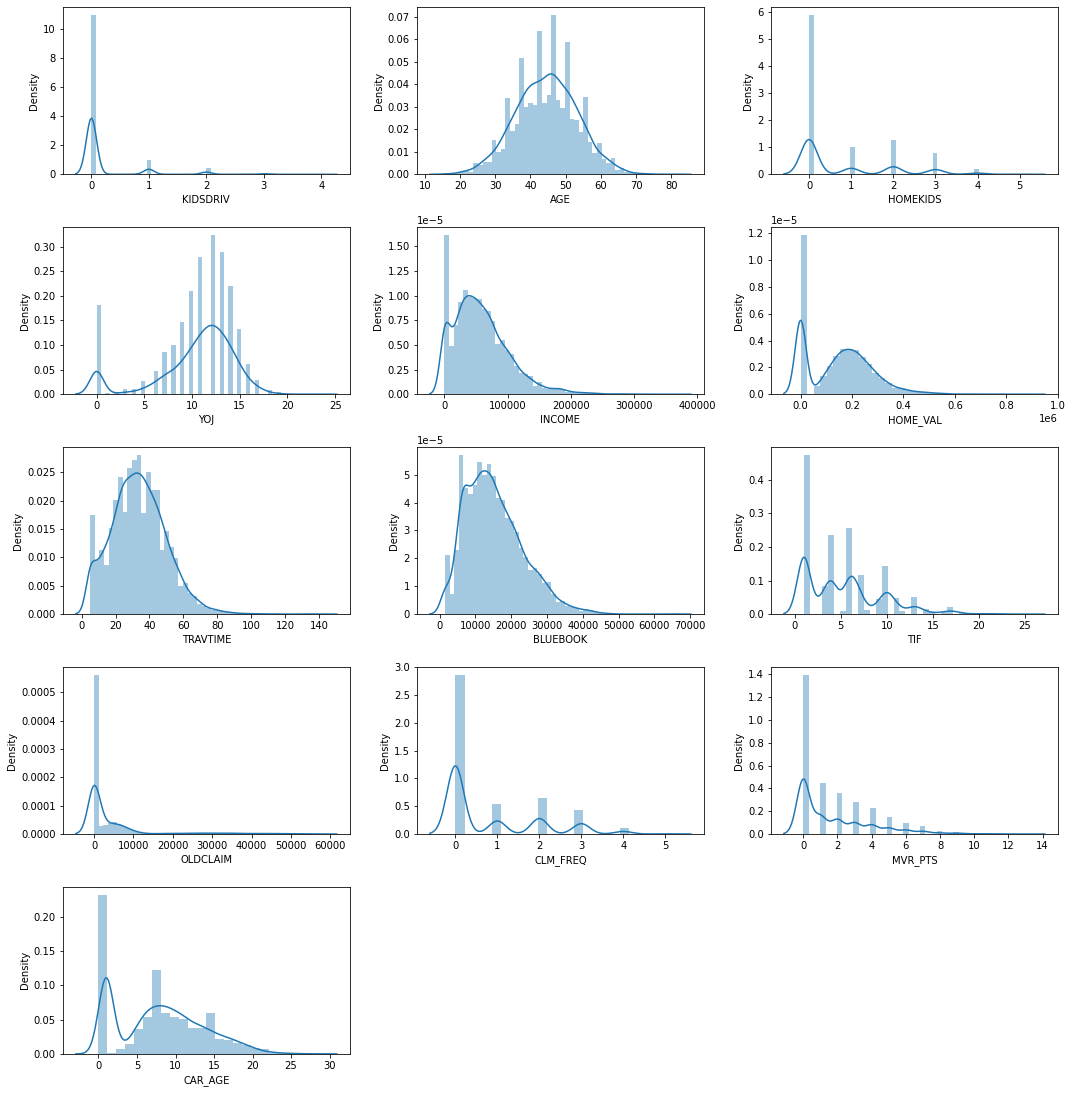

In [17]:
#Understanding the feature set

print('\033[1mFeatures Distribution'.center(100))

nf = [i for i in features if i not in cf]

plt.figure(figsize=[15,3*math.ceil(len(features)/3)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/3),3,c+1)
    sns.distplot(df[nf[c]])
plt.tight_layout()
plt.show()

We can see that some of the data is normally distributed, with a slight skewness. We also choose to keep the 'KIDSDRIV' and 'HOMEKIDS' features as numerical, as there is a natural order to them - i.e. ordinal encodings.

*Note: feature scaling will be required.*

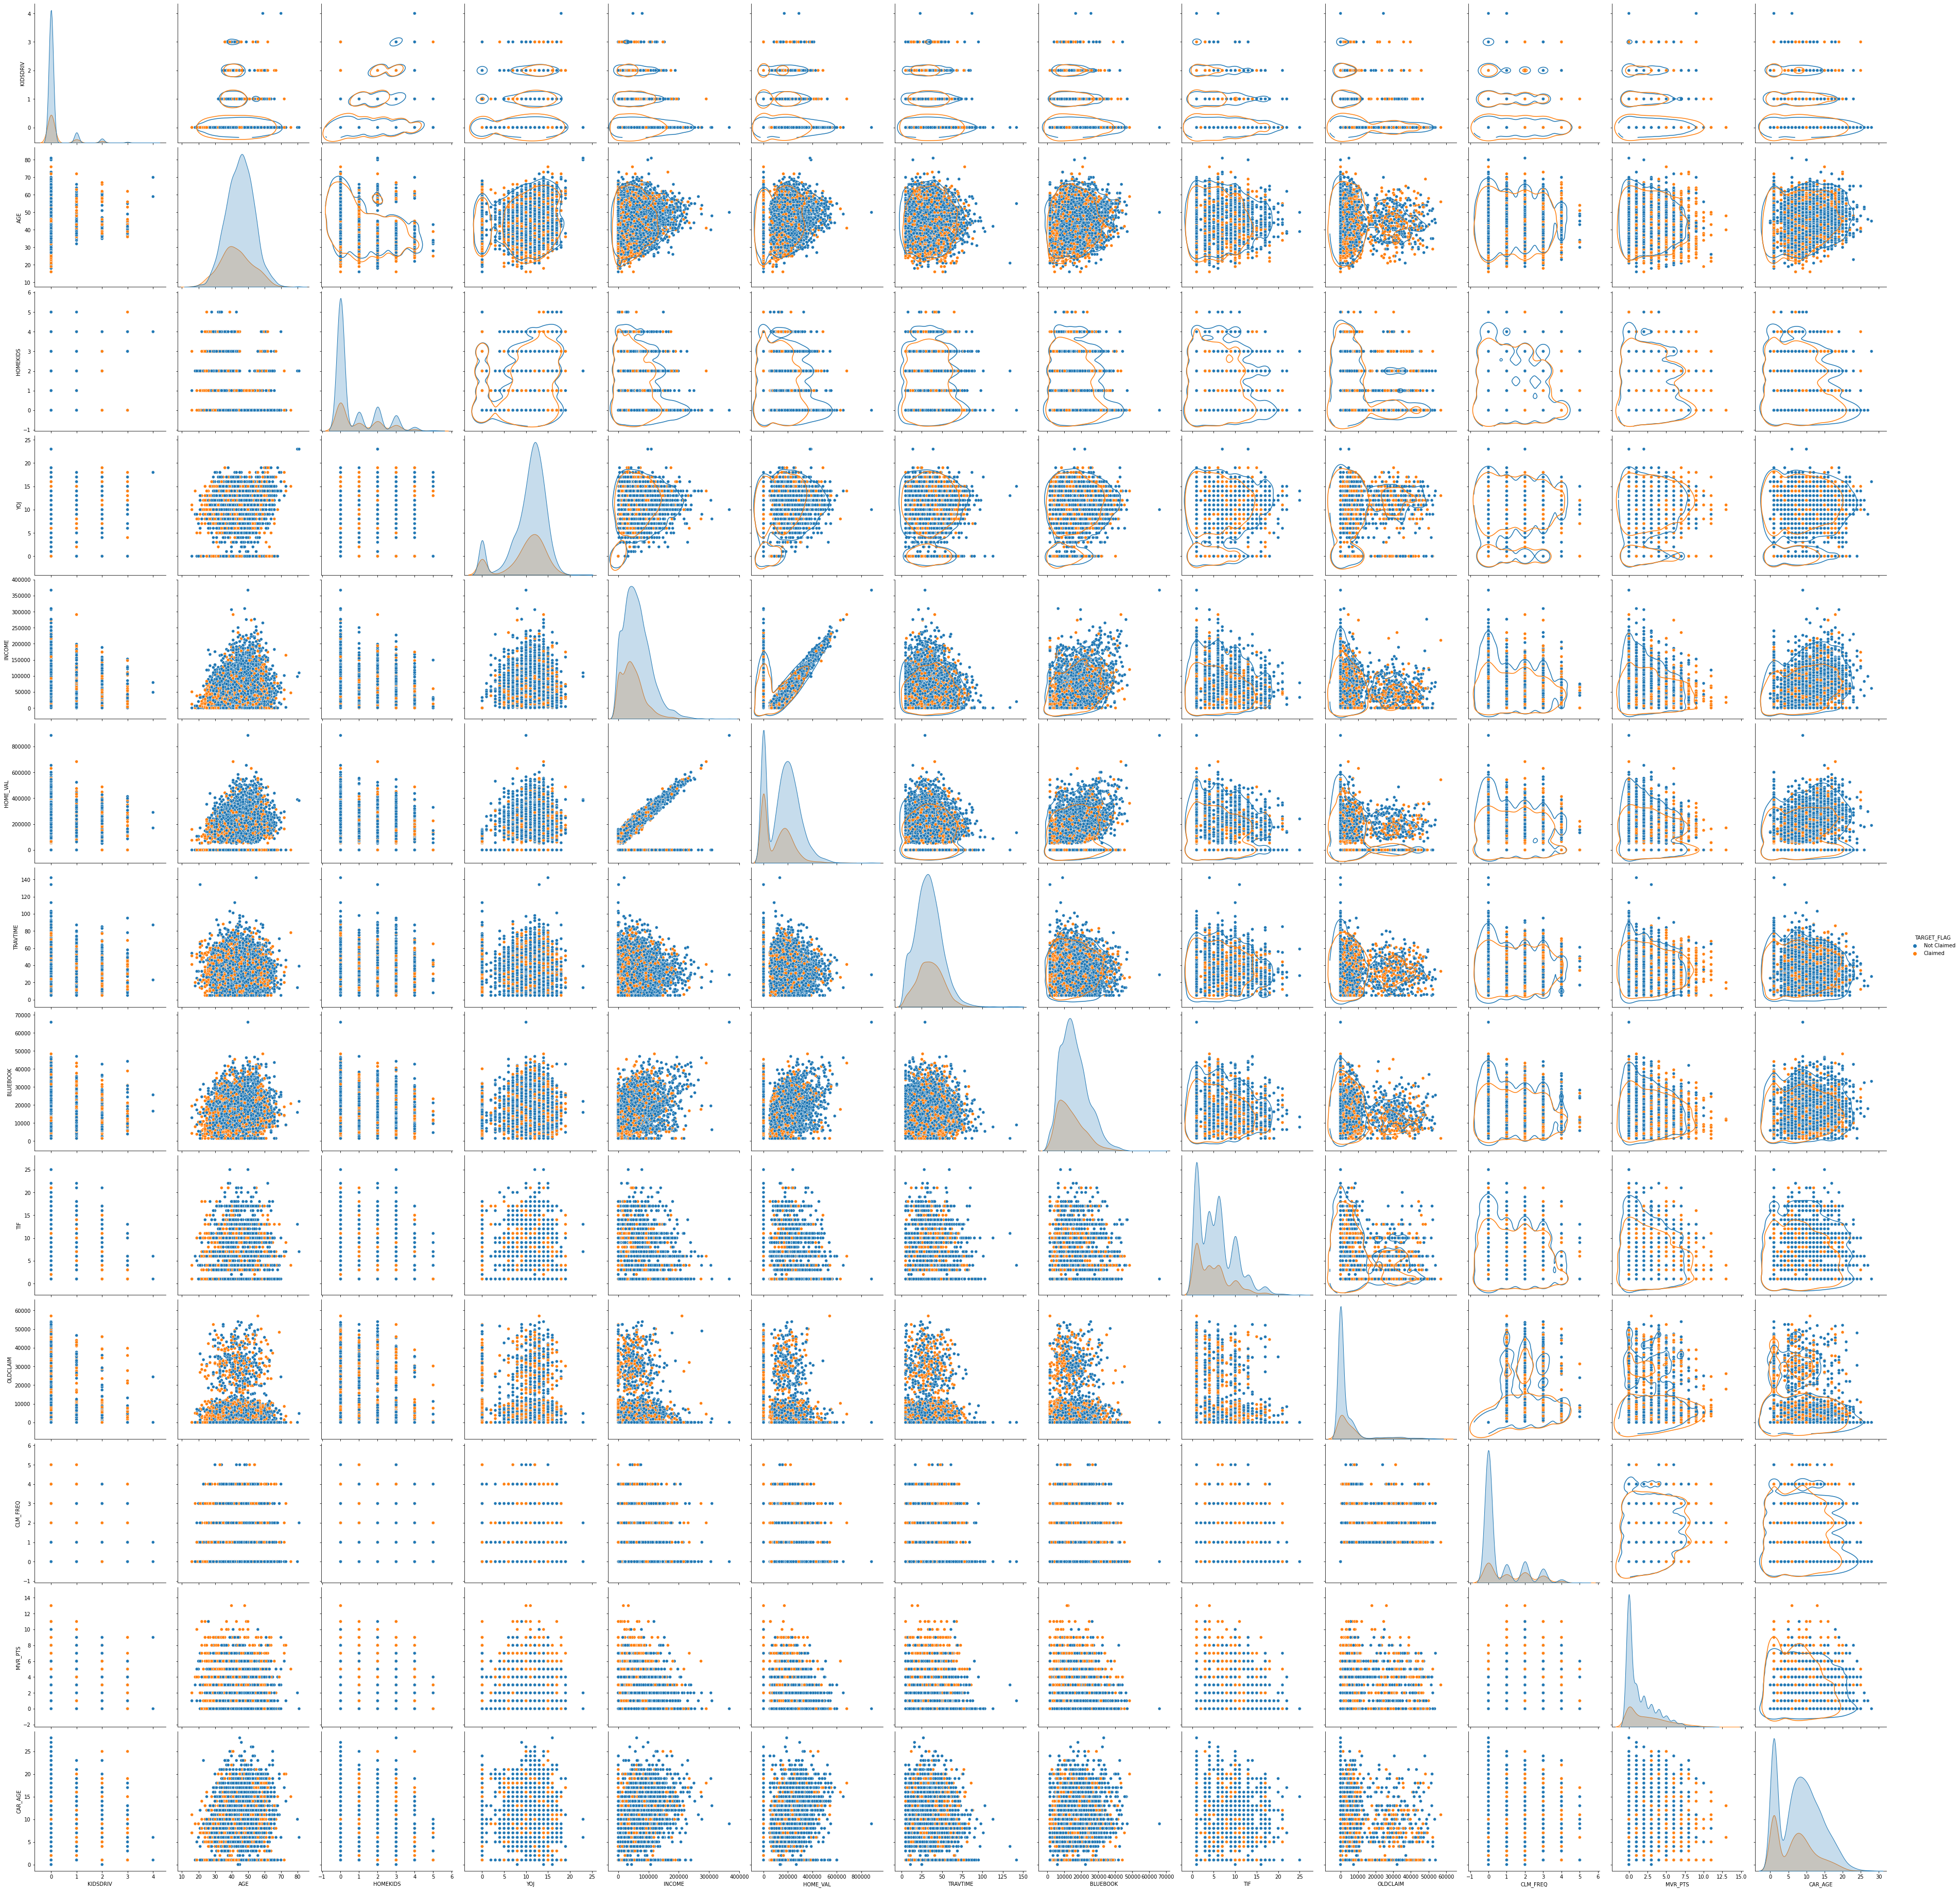

In [18]:
#Understanding the relationship between all the features

g=sns.pairplot(df1, hue=target, height=4)
g.map_upper(sns.kdeplot, levels=1, color=".2")
plt.show()

Here we can see that some features show stronger patterns than others. This information will be useful when designing our model.

In [19]:
#One-hot encoding: categorical -> numerical

df = pd.get_dummies(df, prefix={'PARENT1':'parent', 
                                      'MSTATUS':'mstatus',
                                      'SEX':'sex',
                                      'EDUCATION':'education',
                                      'JOB':'job',
                                      'CAR_USE':'car_use',
                                      'CAR_TYPE':'car_type',
                                      'RED_CAR':'red_car',
                                      'REVOKED':'revoked',
                                      'URBANICITY':'urban'},
                          drop_first=False)

df.rename(columns={'education_<High School': 'education_lessthan High School'}, inplace=True) # As XGBClassifier cannot take '<' in feature name

df.shape

(6044, 47)

In [20]:
# print(df.columns)

              # Index(['TARGET_FLAG', 'KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
              #        'HOME_VAL', 'TRAVTIME', 'BLUEBOOK', 'TIF', 'OLDCLAIM', 'CLM_FREQ',
              #        'MVR_PTS', 'CAR_AGE', 'parent_No', 'parent_Yes', 'mstatus_Yes',
              #        'mstatus_z_No', 'sex_M', 'sex_z_F', 'education_<High School',
              #        'education_Bachelors', 'education_Masters', 'education_PhD',
              #        'education_z_High School', 'job_Clerical', 'job_Doctor',
              #        'job_Home Maker', 'job_Lawyer', 'job_Manager', 'job_Professional',
              #        'job_Student', 'job_z_Blue Collar', 'car_use_Commercial',
              #        'car_use_Private', 'car_type_Minivan', 'car_type_Panel Truck',
              #        'car_type_Pickup', 'car_type_Sports Car', 'car_type_Van',
              #        'car_type_z_SUV', 'red_car_no', 'red_car_yes', 'revoked_No',
              #        'revoked_Yes', 'urban_Highly Urban/ Urban',
              #        'urban_z_Highly Rural/ Rural'],
              #       dtype='object')

To address the data imbalance, we can use SMOTE to match sample sizes from each class.

In [21]:
#Fixing the class imbalance using SMOTE Technique

print('Original class distribution:')
print(df[target].value_counts())

xf = df.columns
X = df.drop([target],axis=1)
Y = df[target]

smote = SMOTE()
X, Y = smote.fit_resample(X, Y)

df = pd.DataFrame(X, columns=xf)
df[target] = Y

print('\nClass distribution after applying SMOTE Technique:',)
print(Y.value_counts())

Original class distribution:
0    4443
1    1601
Name: TARGET_FLAG, dtype: int64

Class distribution after applying SMOTE Technique:
0    4443
1    4443
Name: TARGET_FLAG, dtype: int64


In [22]:
print(df.shape)

(8886, 47)


Final dataset has 8886 samples with 46 features.

# Data manipulation

In [23]:
#Split data into training & validation sets

X = df.drop([target],axis=1)
Y = df[target]
train_X, val_X, train_Y, val_Y = train_test_split(X, Y, train_size=0.8, random_state=0)
print('Train features: {}, val features {}'.format(train_X.shape,val_X.shape))
print('Train targets: {}, val targets {}'.format(train_Y.shape,val_Y.shape))

Train features: (7108, 46), val features (1778, 46)
Train targets: (7108,), val targets (1778,)


Splitting our data into training and validation sets allows us to test performance, tune hyperparameters, and compare methods.

In [24]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(100))
train_X_std = std.fit_transform(train_X)
train_X_std = pd.DataFrame(train_X_std, columns=X.columns)
display(train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(100))
val_X_std = std.transform(val_X)
val_X_std = pd.DataFrame(val_X_std, columns=X.columns)
display(val_X_std.describe())

                               Standardardization on Training set                               


KIDSDRIV           AGE      HOMEKIDS           YOJ        INCOME  \
count  7.108000e+03  7.108000e+03  7.108000e+03  7.108000e+03  7.108000e+03   
mean   4.048534e-17 -4.091019e-16 -6.972475e-17  3.828614e-16 -4.073525e-17   
std    1.000070e+00  1.000070e+00  1.000070e+00  1.000070e+00  1.000070e+00   
min   -3.271864e-01 -3.250760e+00 -6.714241e-01 -2.487496e+00 -1.287634e+00   
25%   -3.271864e-01 -7.032623e-01 -6.714241e-01 -3.200323e-01 -7.089568e-01   
50%   -3.271864e-01 -8.490098e-03 -6.714241e-01  1.616264e-01 -1.519870e-01   
75%   -3.271864e-01  6.862821e-01  2.725005e-01  6.432850e-01  5.065790e-01   
max    8.008443e+00  4.275938e+00  4.048199e+00  3.051578e+00  7.363064e+00   

           HOME_VAL      TRAVTIME      BLUEBOOK           TIF      OLDCLAIM  \
count  7.108000e+03  7.108000e+03  7.108000e+03  7.108000e+03  7.108000e+03   
mean   1.009634e-16 -1.439479e-16  3.498733e-17 -4.498371e-17  3.398769e-17   
std    1.000070e+00  1.000070e+00  1.000070e+00  1.000070e+00  1.000070e+00   
min   -1.138681e+00 -1.952974e+00 -1.695269e+00 -1.041670e+00 -5.010526e-01   
25%   -1.138681e+00 -6.719417e-01 -7.697543e-01 -1.041670e+00 -5.010526e-01   
50%    6.945851e-02  2.286000e-03 -1.575417e-01 -2.670652e-01 -5.010526e-01   
75%    6.713202e-01  6.765137e-01  5.988488e-01  5.075401e-01  7.346761e-02   
max    6.175692e+00  6.744563e+00  6.552426e+00  5.155172e+00  5.742726e+00   

       ...  car_type_Pickup  car_type_Sports Car  car_type_Van  \
count  ...     7.108000e+03         7.108000e+03  7.108000e+03   
mean   ...    -7.322349e-17         4.898227e-17 -5.098154e-17   
std    ...     1.000070e+00         1.000070e+00  1.000070e+00   
min    ...    -3.901444e-01        -3.107654e-01 -2.435456e-01   
25%    ...    -3.901444e-01        -3.107654e-01 -2.435456e-01   
50%    ...    -3.901444e-01        -3.107654e-01 -2.435456e-01   
75%    ...    -3.901444e-01        -3.107654e-01 -2.435456e-01   
max    ...     2.563153e+00         3.217861e+00  4.106007e+00   

       car_type_z_SUV    red_car_no   red_car_yes    revoked_No   revoked_Yes  \
count    7.108000e+03  7.108000e+03  7.108000e+03  7.108000e+03  7.108000e+03   
mean     1.999276e-18 -7.597249e-17  3.998552e-17  2.998914e-17 -1.999276e-18   
std      1.000070e+00  1.000070e+00  1.000070e+00  1.000070e+00  1.000070e+00   
min     -5.578505e-01 -1.393139e+00 -5.206742e-01 -2.164809e+00 -3.638517e-01   
25%     -5.578505e-01 -1.393139e+00 -5.206742e-01  4.619344e-01 -3.638517e-01   
50%     -5.578505e-01  7.178036e-01 -5.206742e-01  4.619344e-01 -3.638517e-01   
75%     -5.578505e-01  7.178036e-01 -5.206742e-01  4.619344e-01 -3.638517e-01   
max      1.792595e+00  7.178036e-01  1.920587e+00  4.619344e-01  2.748372e+00   

       urban_Highly Urban/ Urban  urban_z_Highly Rural/ Rural  
count               7.108000e+03                 7.108000e+03  
mean               -8.097068e-17                -1.999276e-17  
std                 1.000070e+00                 1.000070e+00  
min                -2.115684e+00                -4.163226e-01  
25%                 4.726605e-01                -4.163226e-01  
50%                 4.726605e-01                -4.163226e-01  
75%                 4.726605e-01                -4.163226e-01  
max                 4.726605e-01                 2.401983e+00  

[8 rows x 46 columns]


                                Standardardization on Testing set                                


KIDSDRIV          AGE     HOMEKIDS          YOJ       INCOME  \
count  1778.000000  1778.000000  1778.000000  1778.000000  1778.000000   
mean     -0.002528    -0.024798    -0.000378    -0.035789     0.007346   
std       0.978570     0.993877     0.999751     1.038817     1.019333   
min      -0.327186    -3.019170    -0.671424    -2.487496    -1.287634   
25%      -0.327186    -0.703262    -0.671424    -0.320032    -0.732674   
50%      -0.327186    -0.008490    -0.671424     0.161626    -0.148534   
75%      -0.327186     0.686282     0.272500     0.643285     0.547820   
max       5.924536     3.349576     4.048199     2.088261     5.203206   

          HOME_VAL     TRAVTIME     BLUEBOOK          TIF     OLDCLAIM  ...  \
count  1778.000000  1778.000000  1778.000000  1778.000000  1778.000000  ...   
mean      0.006697     0.011842    -0.019667     0.024537    -0.039209  ...   
std       1.016951     1.021641     0.988189     1.008366     0.953187  ...   
min      -1.138681    -1.952974    -1.695269    -1.041670    -0.501053  ...   
25%      -1.138681    -0.671942    -0.794029    -1.041670    -0.501053  ...   
50%       0.052087     0.002286    -0.163299    -0.267065    -0.501053  ...   
75%       0.715445     0.676514     0.624435     0.507540     0.049685  ...   
max       4.264399     7.283945     4.302124     4.380567     5.242234  ...   

       car_type_Pickup  car_type_Sports Car  car_type_Van  car_type_z_SUV  \
count      1778.000000          1778.000000   1778.000000     1778.000000   
mean         -0.013092            -0.015059      0.052459        0.001339   
std           0.985863             0.978025      1.095693        1.001107   
min          -0.390144            -0.310765     -0.243546       -0.557851   
25%          -0.390144            -0.310765     -0.243546       -0.557851   
50%          -0.390144            -0.310765     -0.243546       -0.557851   
75%          -0.390144            -0.310765     -0.243546       -0.557851   
max           2.563153             3.217861      4.106007        1.792595   

        red_car_no  red_car_yes   revoked_No  revoked_Yes  \
count  1778.000000  1778.000000  1778.000000  1778.000000   
mean      0.010199    -0.007158     0.011340    -0.010269   
std       0.996778     0.995231     0.990511     0.987905   
min      -1.393139    -0.520674    -2.164809    -0.363852   
25%      -1.393139    -0.520674     0.461934    -0.363852   
50%       0.717804    -0.520674     0.461934    -0.363852   
75%       0.717804    -0.520674     0.461934    -0.363852   
max       0.717804     1.920587     0.461934     2.748372   

       urban_Highly Urban/ Urban  urban_z_Highly Rural/ Rural  
count                1778.000000                  1778.000000  
mean                   -0.009197                     0.002143  
std                     1.007768                     1.002406  
min                    -2.115684                    -0.416323  
25%                     0.472660                    -0.416323  
50%                     0.472660                    -0.416323  
75%                     0.472660                    -0.416323  
max                     0.472660                     2.401983  

[8 rows x 46 columns]

We perform some scaling of features to ensure that different magnitudes do not cause bias in the models.

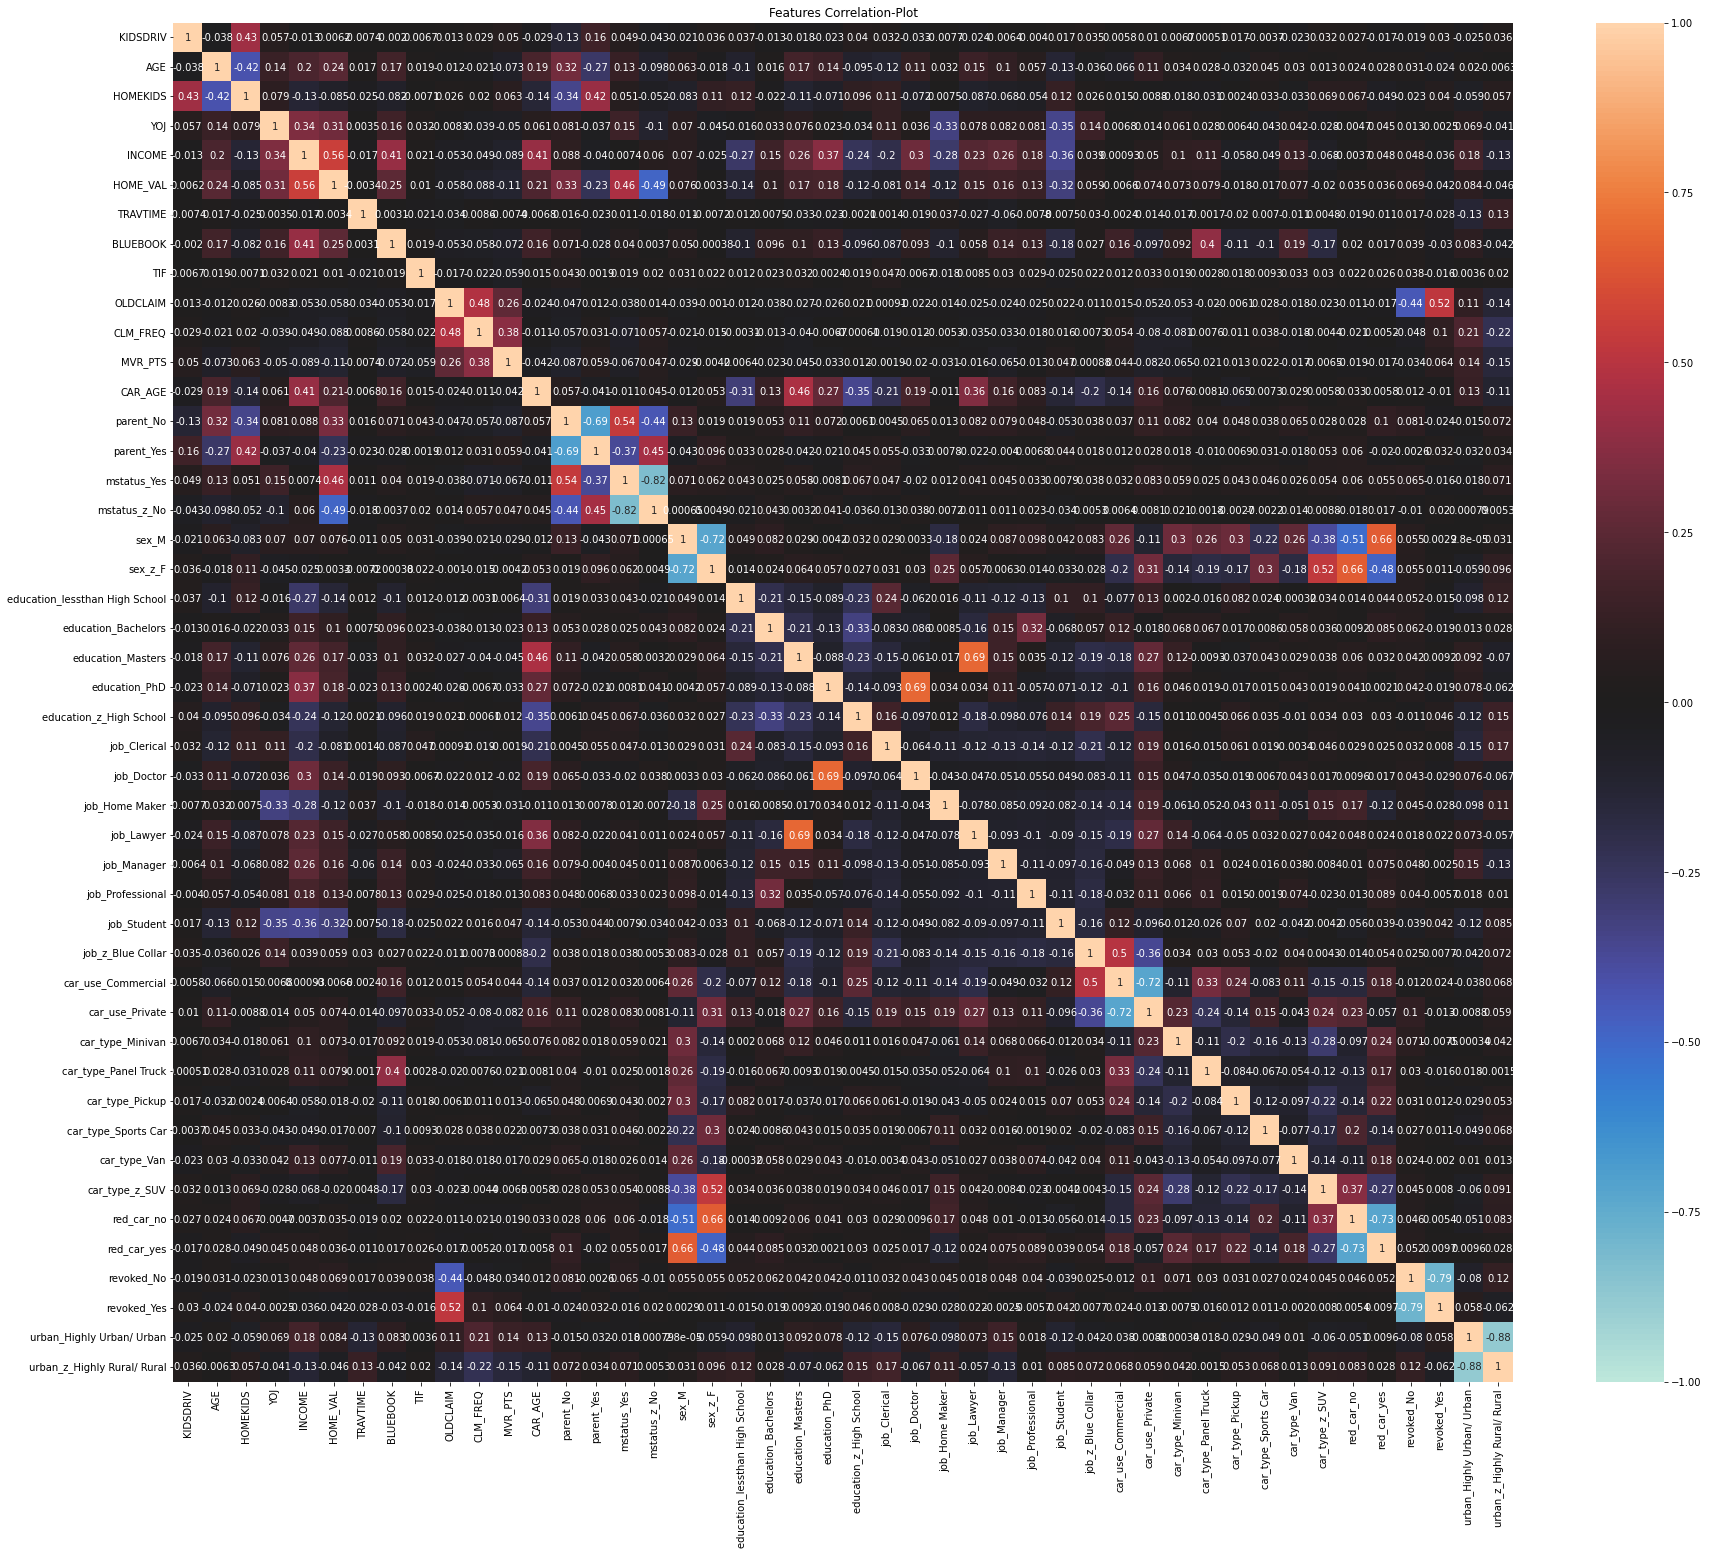

In [25]:
#Checking the correlation

features = df.drop([target],axis=1).columns
plt.figure(figsize=[30,25])
plt.title('Features Correlation-Plot')
sns.heatmap(df[features].corr(), vmin=-1, vmax=1, center=0, annot=True)
plt.show()

Here, we can see that there is some strong multicollinearity between some features.

Using feature selection/extraction, we can address these redundancies. We choose to compare two popular choices: PCA & RFE

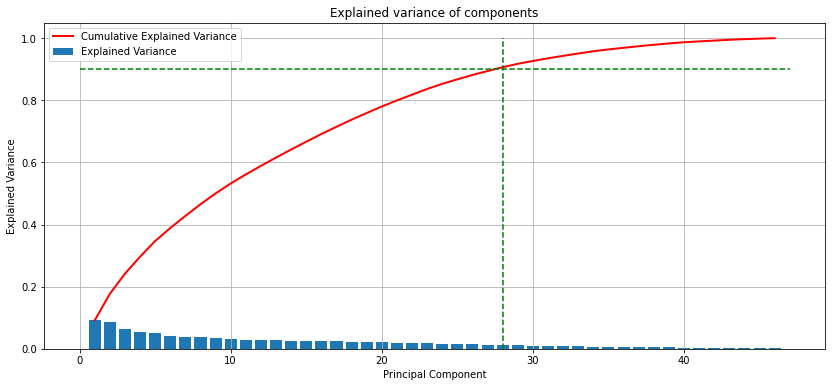

In [26]:
pca = PCA().fit(train_X_std)

fig, ax = plt.subplots(figsize=(14,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.90,0.90],'g--')
plt.plot([28,28],[0,1], 'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.grid()
plt.legend()
plt.show()

100%|██████████| 46/46 [03:40<00:00,  4.79s/it]


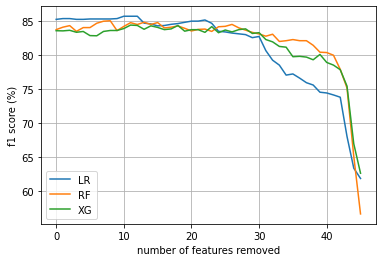

In [27]:
#Applying PCA Transformations

scores1=[]; scores2=[]; scores3=[]
for i in tqdm(range(len(X.columns.values))):
    pca = PCA(n_components=train_X_std.shape[1]-i)
    train_X_std_pca = pca.fit_transform(train_X_std)
    train_X_std_pca = pd.DataFrame(train_X_std_pca)

    val_X_std_pca = pca.transform(val_X_std)
    val_X_std_pca = pd.DataFrame(val_X_std_pca)
    
    scores1.append(f1_score(val_Y,LogisticRegression().fit(train_X_std_pca, train_Y).predict(val_X_std_pca),average='weighted')*100)
    scores2.append(f1_score(val_Y,RandomForestClassifier().fit(train_X_std_pca, train_Y).predict(val_X_std_pca),average='weighted')*100)
    scores3.append(f1_score(val_Y,XGBClassifier().fit(train_X_std_pca, train_Y, eval_metric='logloss').predict(val_X_std_pca),average='weighted')*100)

    
plt.plot(scores1, label='LR')
plt.plot(scores2, label='RF')
plt.plot(scores3, label='XG')
plt.xlabel('number of features removed')
plt.ylabel('f1 score (%)')
plt.legend()
plt.grid()
plt.show()

100%|██████████| 46/46 [02:40<00:00,  3.50s/it]


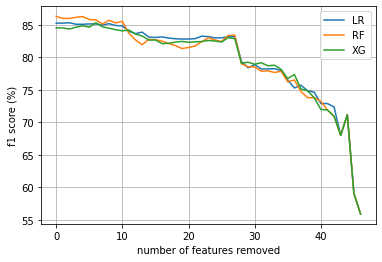

In [28]:
# Applying Recurrsive Feature Elimination

LR = LogisticRegression()
scores1=[]; scores2=[]; scores3=[]
scores1.append(f1_score(val_Y,LogisticRegression().fit(train_X_std, train_Y).predict(val_X_std),average='weighted')*100)
scores2.append(f1_score(val_Y,RandomForestClassifier().fit(train_X_std, train_Y).predict(val_X_std),average='weighted')*100)
scores3.append(f1_score(val_Y,XGBClassifier().fit(train_X_std, train_Y, eval_metric='logloss').predict(val_X_std),average='weighted')*100)

for i in tqdm(range(len(X.columns.values))):
    rfe = RFE(LR,n_features_to_select=len(train_X_std.columns)-i)   
    rfe = rfe.fit(train_X_std, train_Y)
    scores1.append(f1_score(val_Y,LogisticRegression().fit(train_X_std[train_X_std.columns[rfe.support_]], train_Y).predict(val_X_std[train_X_std.columns[rfe.support_]]),average='weighted')*100)
    scores2.append(f1_score(val_Y,RandomForestClassifier().fit(train_X_std[train_X_std.columns[rfe.support_]], train_Y).predict(val_X_std[train_X_std.columns[rfe.support_]]),average='weighted')*100)
    scores3.append(f1_score(val_Y,XGBClassifier().fit(train_X_std[train_X_std.columns[rfe.support_]], train_Y, eval_metric='logloss').predict(val_X_std[train_X_std.columns[rfe.support_]]),average='weighted')*100)
    
plt.plot(scores1, label='LR')
plt.plot(scores2, label='RF')
plt.plot(scores3, label='XG')
plt.xlabel('number of features removed')
plt.ylabel('f1 score (%)')
plt.legend()
plt.grid()
plt.show()

Therefore, we can see that PCA outperforms RFE in reducing dimensionality while retaining information (~23 features can be discarded while retaining ~85% performance using each model).

In [29]:
# Time to PCA!

pca = PCA(n_components=23)

train_X_std_pca = pca.fit_transform(train_X_std)
# train_X_std_pca = pd.DataFrame(train_X_std_pca)
val_X_std_pca = pca.transform(val_X_std)

print(train_X_std_pca.shape)
print(val_X_std_pca.shape)

(7108, 23)
(1778, 23)


# Training

We will compare four common methods for classification: Logistic Regression, Random Forest, Naive Bayes, and K-Nearest Neighbours.

In [30]:
Evaluation_Results = pd.DataFrame(np.zeros((4,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
Evaluation_Results.index=['Logistic Regression (LR)','Random Forest Classifier (RF)','Naïve Bayes Classifier (NB)',
                         'K Nearest Neighbours (KNN)']

In [31]:
def Classification_Summary(pred,pred_prob,i):
    Evaluation_Results.iloc[i]['Accuracy']=round(accuracy_score(val_Y, pred),3)*100   
    Evaluation_Results.iloc[i]['Precision']=round(precision_score(val_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['Recall']=round(recall_score(val_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['F1-score']=round(f1_score(val_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['AUC-ROC score']=round(roc_auc_score(val_Y, pred_prob[:,1], multi_class='ovr'),3)*100 #[:, 1]
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,Evaluation_Results.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(val_Y, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(val_Y, pred, average='weighted'),3)*100)) #
    print('\n \033[1mConfusion Matrix:\033[0m\n',confusion_matrix(val_Y, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(val_Y, pred))

    auc_roc(val_Y, pred_prob, curves=['each_class'])
    plt.show()

<<<----------------------------------- Evaluating Logistic Regression (LR) ----------------------------------->>>

Accuracy = 84.8%
F1 Score = 84.8%

 Confusion Matrix:
 [[776  86]
 [184 732]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85       862
           1       0.89      0.80      0.84       916

    accuracy                           0.85      1778
   macro avg       0.85      0.85      0.85      1778
weighted avg       0.85      0.85      0.85      1778



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


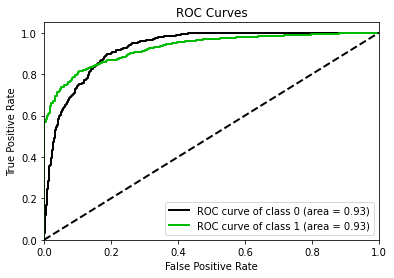


Interpreting the Output of Logistic Regression:

intercept  0.7059440649076919
classes [0 1]


In [32]:
#Logistic Regression

model = LogisticRegression()

param = {
    'C': np.logspace(-5,10,50),
    'penalty': ['l2']
}

cv = GridSearchCV(model,param,scoring='f1',cv=10)

LR = cv.fit(train_X_std_pca, train_Y).best_estimator_
pred = LR.predict(val_X_std_pca)
pred_prob = LR.predict_proba(val_X_std_pca)
Classification_Summary(pred,pred_prob,0)

print('\n\033[1mInterpreting the Output of Logistic Regression:\n\033[0m')

print('intercept ', LR.intercept_[0])
print('classes', LR.classes_)

<<<----------------------------------- Evaluating Random Forest Classifier (RF) ----------------------------------->>>

Accuracy = 83.7%
F1 Score = 83.7%

 Confusion Matrix:
 [[768  94]
 [195 721]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84       862
           1       0.88      0.79      0.83       916

    accuracy                           0.84      1778
   macro avg       0.84      0.84      0.84      1778
weighted avg       0.84      0.84      0.84      1778



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


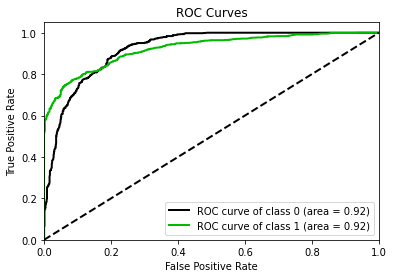


Interpreting the output of Random Forest:



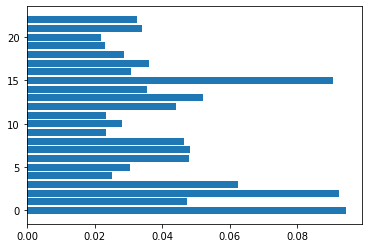

In [33]:
#Random Forest

model = RandomForestClassifier()

param = {'bootstrap': [True, False],
        'max_depth': [10, 20, 50, 100, None],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [50, 100]}

# cv = GridSearchCV(model,param,scoring='f1',cv=10)
cv = RandomizedSearchCV(model, param, n_iter=200, scoring='f1', n_jobs=-1, cv=5, random_state=1)

RF = cv.fit(train_X_std_pca, train_Y).best_estimator_
pred = RF.predict(val_X_std_pca)
pred_prob = RF.predict_proba(val_X_std_pca)
Classification_Summary(pred,pred_prob,1)

print('\n\033[1mInterpreting the output of Random Forest:\n\033[0m')
rfi=pd.Series(RF.feature_importances_, index=pd.DataFrame(train_X_std_pca).columns).sort_values(ascending=False)
plt.barh(rfi.index,rfi.values)
plt.show()

<<<----------------------------------- Evaluating Naïve Bayes Classifier (NB) ----------------------------------->>>

Accuracy = 76.2%
F1 Score = 76.2%

 Confusion Matrix:
 [[703 159]
 [264 652]]

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.82      0.77       862
           1       0.80      0.71      0.76       916

    accuracy                           0.76      1778
   macro avg       0.77      0.76      0.76      1778
weighted avg       0.77      0.76      0.76      1778



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


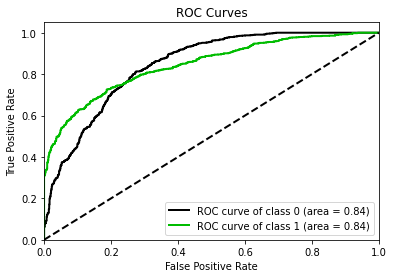

In [34]:
#Naïve Bayes

model = BernoulliNB()

param = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}

cv = GridSearchCV(model,param,scoring='f1',cv=10)

NB = cv.fit(train_X_std_pca, train_Y).best_estimator_
pred = NB.predict(val_X_std_pca)
pred_prob = NB.predict_proba(val_X_std_pca)
Classification_Summary(pred,pred_prob,2)

<<<----------------------------------- Evaluating K Nearest Neighbours (KNN) ----------------------------------->>>

Accuracy = 83.39999999999999%
F1 Score = 83.39999999999999%

 Confusion Matrix:
 [[717 145]
 [151 765]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83       862
           1       0.84      0.84      0.84       916

    accuracy                           0.83      1778
   macro avg       0.83      0.83      0.83      1778
weighted avg       0.83      0.83      0.83      1778



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


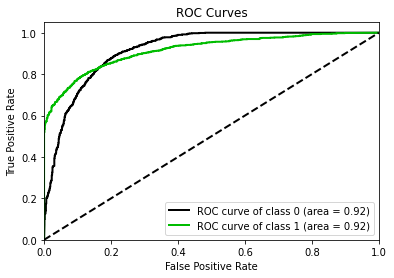

In [35]:
#K-Nearest Neighbours

model = KNeighborsClassifier()

param = {"n_neighbors": [i for i in range(1,30,5)],
             "weights": ["uniform", "distance"],
             "algorithm": ["ball_tree", "kd_tree", "brute"],
             "leaf_size": [1, 10, 30],
             "p": [1,2]}

# cv = GridSearchCV(model,param,scoring='f1',cv=5)
cv = RandomizedSearchCV(model, param, n_iter=100, scoring='f1', n_jobs=-1, cv=5, random_state=1)

KNN = cv.fit(train_X_std_pca, train_Y).best_estimator_
pred = KNN.predict(val_X_std_pca)
pred_prob = KNN.predict_proba(val_X_std_pca)
Classification_Summary(pred,pred_prob,3)

                                    ML Algorithms Comparison                                    


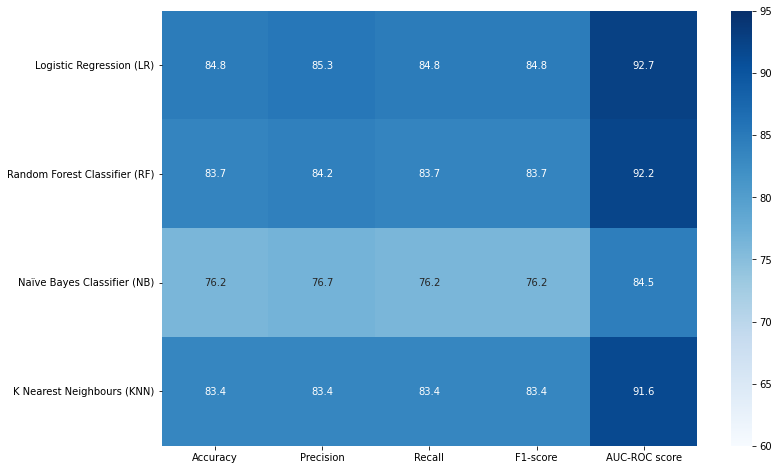

In [36]:
print('\033[1mML Algorithms Comparison'.center(100))
plt.figure(figsize=[12,8])
sns.heatmap(Evaluation_Results, annot=True, vmin=60, vmax=95, cmap='Blues', fmt='.1f')
plt.show()

We can see that Naive Bayes classifier performs the worst overall, and the other three perform much better with similar accuracy. The best performer was the Logistic Regression model.

# Conclusions

*   Our dataset of 8161 samples was processed with 2117 samples dropped.
*   The dataset was extremely unbalanced (~3:1 balance), and so we used SMOTE to balance each class - resulting in 8886 samples.
*   Feature scaling normalised our data.
*   We used one hot encoding to convert categorical data into numerical. Our final dataset of 8886 samples had 46 features.
*   Splitting our data into a training and validation set (80:20 split), we tested different feature selection/extraction methods to reduce dimensionality & reduce curse of dimensionality.
*   Using PCA with 23 components, we trained different classification models with hyperparameter tuning. Decision tree and clustering models (Random Forest, K-Nearest Neighbour) performed well; logistic regression performed best.
*   As such, we should continue with our **logistic regression** model to ensure generalisability and avoid overfitting.



# Testing

In [37]:
#Loading test data

test_df = pd.read_csv('/content/test_auto.csv')
test_df.drop(columns='INDEX',inplace=True)
test_df.drop(columns='TARGET_AMT',inplace=True) # Not needed for this case study

test_df.head()

TARGET_FLAG  KIDSDRIV   AGE  HOMEKIDS   YOJ   INCOME PARENT1 HOME_VAL  \
0          NaN         0  48.0         0  11.0  $52,881      No       $0   
1          NaN         1  40.0         1  11.0  $50,815     Yes       $0   
2          NaN         0  44.0         2  12.0  $43,486     Yes       $0   
3          NaN         0  35.0         2   NaN  $21,204     Yes       $0   
4          NaN         0  59.0         0  12.0  $87,460      No       $0   

  MSTATUS  SEX  ... BLUEBOOK TIF  CAR_TYPE RED_CAR OLDCLAIM  CLM_FREQ REVOKED  \
0    z_No    M  ...  $21,970   1       Van     yes       $0         0      No   
1    z_No    M  ...  $18,930   6   Minivan      no   $3,295         1      No   
2    z_No  z_F  ...   $5,900  10     z_SUV      no       $0         0      No   
3    z_No    M  ...   $9,230   6    Pickup      no       $0         0     Yes   
4    z_No    M  ...  $15,420   1   Minivan     yes  $44,857         2      No   

  MVR_PTS CAR_AGE             URBANICITY  
0       2    10.0    Highly Urban/ Urban  
1       2     1.0    Highly Urban/ Urban  
2       0    10.0  z_Highly Rural/ Rural  
3       0     4.0  z_Highly Rural/ Rural  
4       4     1.0    Highly Urban/ Urban  

[5 rows x 24 columns]

In [38]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2141 entries, 0 to 2140
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  0 non-null      float64
 1   KIDSDRIV     2141 non-null   int64  
 2   AGE          2140 non-null   float64
 3   HOMEKIDS     2141 non-null   int64  
 4   YOJ          2047 non-null   float64
 5   INCOME       2016 non-null   object 
 6   PARENT1      2141 non-null   object 
 7   HOME_VAL     2030 non-null   object 
 8   MSTATUS      2141 non-null   object 
 9   SEX          2141 non-null   object 
 10  EDUCATION    2141 non-null   object 
 11  JOB          2002 non-null   object 
 12  TRAVTIME     2141 non-null   int64  
 13  CAR_USE      2141 non-null   object 
 14  BLUEBOOK     2141 non-null   object 
 15  TIF          2141 non-null   int64  
 16  CAR_TYPE     2141 non-null   object 
 17  RED_CAR      2141 non-null   object 
 18  OLDCLAIM     2141 non-null   object 
 19  CLM_FR

In [39]:
features = test_df.drop([target],axis=1)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2141 entries, 0 to 2140
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   KIDSDRIV    2141 non-null   int64  
 1   AGE         2140 non-null   float64
 2   HOMEKIDS    2141 non-null   int64  
 3   YOJ         2047 non-null   float64
 4   INCOME      2016 non-null   object 
 5   PARENT1     2141 non-null   object 
 6   HOME_VAL    2030 non-null   object 
 7   MSTATUS     2141 non-null   object 
 8   SEX         2141 non-null   object 
 9   EDUCATION   2141 non-null   object 
 10  JOB         2002 non-null   object 
 11  TRAVTIME    2141 non-null   int64  
 12  CAR_USE     2141 non-null   object 
 13  BLUEBOOK    2141 non-null   object 
 14  TIF         2141 non-null   int64  
 15  CAR_TYPE    2141 non-null   object 
 16  RED_CAR     2141 non-null   object 
 17  OLDCLAIM    2141 non-null   object 
 18  CLM_FREQ    2141 non-null   int64  
 19  REVOKED     2141 non-null  

We can see that there are a lot of missing values. We can use the stats of our training data to impute our test data.

In [40]:
#Data cleaning - imputation.
#First, we need to convert categorical to numerical

features[['AGE']] = features[['AGE']].fillna(s_age)
features[['YOJ']] = features[['YOJ']].fillna(s_yoj)
features[['CAR_AGE']] = features[['CAR_AGE']].fillna(s_car_age)

#Remove '$' & ',' from INCOME:
features['INCOME'] = features['INCOME'].str.replace('$', '').str.replace(',', '')
features['INCOME'] = pd.to_numeric(features['INCOME'], errors='coerce')
features[['INCOME']] = features[['INCOME']].fillna(s_income).astype(int)

#Remove '$' & ',' from HOME_VAL:
features['HOME_VAL'] = features['HOME_VAL'].str.replace('$', '').str.replace(',', '')
features['HOME_VAL'] = pd.to_numeric(features['HOME_VAL'], errors='coerce')
features[['HOME_VAL']] = features[['HOME_VAL']].fillna(s_home_val).astype(int)

#Remove '$' & ',' from BLUEBOOK:
features['BLUEBOOK'] = features['BLUEBOOK'].str.replace('$', '').str.replace(',', '').astype(int)

#Remove '$' & ',' from OLDCLAIM:
features['OLDCLAIM'] = features['OLDCLAIM'].str.replace('$', '').str.replace(',', '').astype(int)

#Impute JOB:
features['JOB'] = features['JOB'].fillna(s_job.iloc[0])

features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2141 entries, 0 to 2140
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   KIDSDRIV    2141 non-null   int64  
 1   AGE         2141 non-null   float64
 2   HOMEKIDS    2141 non-null   int64  
 3   YOJ         2141 non-null   float64
 4   INCOME      2141 non-null   int64  
 5   PARENT1     2141 non-null   object 
 6   HOME_VAL    2141 non-null   int64  
 7   MSTATUS     2141 non-null   object 
 8   SEX         2141 non-null   object 
 9   EDUCATION   2141 non-null   object 
 10  JOB         2141 non-null   object 
 11  TRAVTIME    2141 non-null   int64  
 12  CAR_USE     2141 non-null   object 
 13  BLUEBOOK    2141 non-null   int64  
 14  TIF         2141 non-null   int64  
 15  CAR_TYPE    2141 non-null   object 
 16  RED_CAR     2141 non-null   object 
 17  OLDCLAIM    2141 non-null   int64  
 18  CLM_FREQ    2141 non-null   int64  
 19  REVOKED     2141 non-null  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In additi

In [41]:
features.nunique()

KIDSDRIV         4
AGE             55
HOMEKIDS         6
YOJ             21
INCOME        1804
PARENT1          2
HOME_VAL      1398
MSTATUS          2
SEX              2
EDUCATION        5
JOB              8
TRAVTIME        83
CAR_USE          2
BLUEBOOK      1417
TIF             21
CAR_TYPE         6
RED_CAR          2
OLDCLAIM       834
CLM_FREQ         6
REVOKED          2
MVR_PTS         13
CAR_AGE         28
URBANICITY       2
dtype: int64

These stats look great, as they match up with the training data stats also.

In [42]:
#One-hot encoding: categorical -> numerical

features = pd.get_dummies(features, prefix={'PARENT1':'parent', 
                                      'MSTATUS':'mstatus',
                                      'SEX':'sex',
                                      'EDUCATION':'education',
                                      'JOB':'job',
                                      'CAR_USE':'car_use',
                                      'CAR_TYPE':'car_type',
                                      'RED_CAR':'red_car',
                                      'REVOKED':'revoked',
                                      'URBANICITY':'urban'},
                          drop_first=False)

features.rename(columns={'education_<High School': 'education_lessthan High School'}, inplace=True) # As XGBClassifier cannot take '<' in feature name

features.shape

(2141, 46)

In [43]:
#Scaling our data using std(), fitted to training data.

print('\n','\033[1mStandardardization on Testing set'.center(100))
features_std = std.transform(features)
features_std = pd.DataFrame(features_std, columns=features.columns)
display(features_std.describe())


                                Standardardization on Testing set                                


KIDSDRIV          AGE     HOMEKIDS          YOJ       INCOME  \
count  2141.000000  2141.000000  2141.000000  2141.000000  2141.000000   
mean      0.011534     0.109232     0.005768     0.013312     0.131223   
std       1.014757     0.986926     1.053966     0.981973     1.075069   
min      -0.327186    -3.134965    -0.671424    -2.487496    -1.287634   
25%      -0.327186    -0.587467    -0.671424    -0.320032    -0.640653   
50%      -0.327186     0.107305    -0.671424     0.161626     0.011491   
75%      -0.327186     0.802077     0.272500     0.643285     0.666698   
max       5.924536     3.349576     4.048199     2.088261     5.575368   

          HOME_VAL     TRAVTIME     BLUEBOOK          TIF     OLDCLAIM  ...  \
count  2141.000000  2141.000000  2141.000000  2141.000000  2141.000000  ...   
mean      0.125894    -0.054871     0.091850     0.054330    -0.060750  ...   
std       1.041505     1.060047     1.082597     1.025326     0.937643  ...   
min      -1.138681    -1.952974    -1.695269    -1.041670    -0.501053  ...   
25%      -1.138681    -0.806787    -0.752420    -1.041670    -0.501053  ...   
50%       0.101400    -0.065137    -0.074387    -0.267065    -0.501053  ...   
75%       0.775992     0.609091     0.805777     0.507540     0.015422  ...   
max       4.390967     4.789303     4.501696     5.155172     5.453947  ...   

       car_type_Pickup  car_type_Sports Car  car_type_Van  car_type_z_SUV  \
count      2141.000000          2141.000000   2141.000000     2141.000000   
mean          0.138166             0.137523      0.103850        0.088769   
std           1.132142             1.175384      1.179398        1.049877   
min          -0.390144            -0.310765     -0.243546       -0.557851   
25%          -0.390144            -0.310765     -0.243546       -0.557851   
50%          -0.390144            -0.310765     -0.243546       -0.557851   
75%          -0.390144            -0.310765     -0.243546        1.792595   
max           2.563153             3.217861      4.106007        1.792595   

        red_car_no  red_car_yes   revoked_No  revoked_Yes  \
count  2141.000000  2141.000000  2141.000000  2141.000000   
mean      0.128199     0.161191     0.141719     0.015546   
std       0.947316     1.095551     0.859610     1.018485   
min      -1.393139    -0.520674    -2.164809    -0.363852   
25%      -1.393139    -0.520674     0.461934    -0.363852   
50%       0.717804    -0.520674     0.461934    -0.363852   
75%       0.717804     1.920587     0.461934    -0.363852   
max       0.717804     1.920587     0.461934     2.748372   

       urban_Highly Urban/ Urban  urban_z_Highly Rural/ Rural  
count                2141.000000                  2141.000000  
mean                   -0.014543                     0.114167  
std                     1.012009                     1.101921  
min                    -2.115684                    -0.416323  
25%                     0.472660                    -0.416323  
50%                     0.472660                    -0.416323  
75%                     0.472660                    -0.416323  
max                     0.472660                     2.401983  

[8 rows x 46 columns]

In [44]:
#PCA transform, fitted to training data.

features_std_pca = pca.transform(features_std)
print(features_std_pca.shape)

(2141, 23)


In [45]:
#Logistic Regression, fitted to training data.

pred = LR.predict(features_std_pca)
pred.shape
targetflag = pd.DataFrame(pred, columns=['TARGET_FLAG'])
targetflag['TARGET_FLAG'].value_counts()

0    1687
1     454
Name: TARGET_FLAG, dtype: int64

In [46]:
#Save to cd

FINAL = pd.concat([targetflag, test_df.drop([target],axis=1)], axis=1)
FINAL.to_csv('output.csv',index=False) 
FINAL.head()

TARGET_FLAG  KIDSDRIV   AGE  HOMEKIDS   YOJ   INCOME PARENT1 HOME_VAL  \
0            0         0  48.0         0  11.0  $52,881      No       $0   
1            0         1  40.0         1  11.0  $50,815     Yes       $0   
2            0         0  44.0         2  12.0  $43,486     Yes       $0   
3            0         0  35.0         2   NaN  $21,204     Yes       $0   
4            0         0  59.0         0  12.0  $87,460      No       $0   

  MSTATUS  SEX  ... BLUEBOOK TIF  CAR_TYPE RED_CAR OLDCLAIM  CLM_FREQ REVOKED  \
0    z_No    M  ...  $21,970   1       Van     yes       $0         0      No   
1    z_No    M  ...  $18,930   6   Minivan      no   $3,295         1      No   
2    z_No  z_F  ...   $5,900  10     z_SUV      no       $0         0      No   
3    z_No    M  ...   $9,230   6    Pickup      no       $0         0     Yes   
4    z_No    M  ...  $15,420   1   Minivan     yes  $44,857         2      No   

  MVR_PTS CAR_AGE             URBANICITY  
0       2    10.0    Highly Urban/ Urban  
1       2     1.0    Highly Urban/ Urban  
2       0    10.0  z_Highly Rural/ Rural  
3       0     4.0  z_Highly Rural/ Rural  
4       4     1.0    Highly Urban/ Urban  

[5 rows x 24 columns]